In [1]:
#@title 檢視GPU
! nvidia-smi

Fri Mar 11 16:54:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#@title 安裝 face-alignment
! pip install face-alignment

  Created wheel for face-alignment: filename=face_alignment-1.3.5-py2.py3-none-any.whl size=28241 sha256=f1fa408996a90bc4ffccd2fa8f1b7cfd20c5fc1765b05fa5d1f0a27957b4d229
  Stored in directory: /root/.cache/pip/wheels/c9/ba/4d/2d368f55e5f929f9472da59e356fbdf1483f885de80a5bc620
Successfully built face-alignment


https://upload.wikimedia.org/wikipedia/commons/thumb/8/8d/President_Barack_Obama.jpg/1200px-President_Barack_Obama.jpg
--2022-03-11 16:54:37--  https://upload.wikimedia.org/wikipedia/commons/thumb/8/8d/President_Barack_Obama.jpg/1200px-President_Barack_Obama.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 308833 (302K) [image/jpeg]
Saving to: ‘src.jpg’

src.jpg             100%[===================>] 301.59K  --.-KB/s    in 0.05s   

2022-03-11 16:54:37 (6.22 MB/s) - ‘src.jpg’ saved [308833/308833]



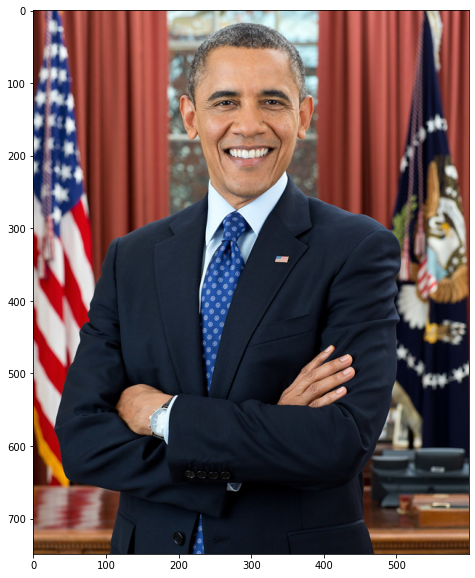

In [3]:
#@title 下載 src 圖檔

import os
from PIL import Image
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/8/8d/President_Barack_Obama.jpg/1200px-President_Barack_Obama.jpg' #@param {type:"string"}
print(url)
cmd=f"wget {url} -O src.jpg"  
! $cmd 

if os.path.isfile('src.jpg'):
  im = Image.open('src.jpg')
  w_ = 600
  h_ = int((w_ / im.width) * im.height)  
  new_img = im.resize((w_,h_))
  plt.figure(figsize = (20,10))
  plt.imshow(new_img)

In [7]:
#@title 2D臉部校正
import face_alignment
from skimage import io

fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, flip_input=False)

input = io.imread('src.jpg')
preds = fa.get_landmarks(input)

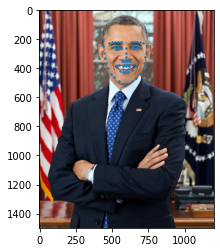

In [8]:
#@title 偵測臉部 landmark
plt.imshow(input)
for detection in preds:
    plt.scatter(detection[:,0], detection[:,1], 2)

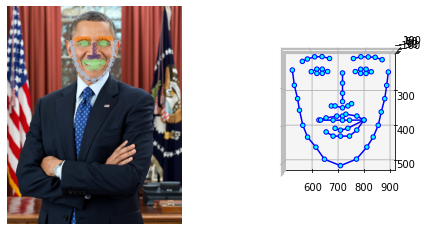

In [10]:
#@title 2D 與 3D 校正 
import face_alignment
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skimage import io
import collections


# Optionally set detector and some additional detector parameters
face_detector = 'sfd'
face_detector_kwargs = {
    "filter_threshold" : 0.8
}

# Run the 3D face alignment on a test image, without CUDA.
fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._3D, device='cpu', flip_input=True,
                                  face_detector=face_detector, face_detector_kwargs=face_detector_kwargs)


input_img = io.imread('src.jpg')

preds = fa.get_landmarks(input_img)[-1]

# 2D-Plot
plot_style = dict(marker='o',
                  markersize=4,
                  linestyle='-',
                  lw=2)

pred_type = collections.namedtuple('prediction_type', ['slice', 'color'])
pred_types = {'face': pred_type(slice(0, 17), (0.682, 0.780, 0.909, 0.5)),
              'eyebrow1': pred_type(slice(17, 22), (1.0, 0.498, 0.055, 0.4)),
              'eyebrow2': pred_type(slice(22, 27), (1.0, 0.498, 0.055, 0.4)),
              'nose': pred_type(slice(27, 31), (0.345, 0.239, 0.443, 0.4)),
              'nostril': pred_type(slice(31, 36), (0.345, 0.239, 0.443, 0.4)),
              'eye1': pred_type(slice(36, 42), (0.596, 0.875, 0.541, 0.3)),
              'eye2': pred_type(slice(42, 48), (0.596, 0.875, 0.541, 0.3)),
              'lips': pred_type(slice(48, 60), (0.596, 0.875, 0.541, 0.3)),
              'teeth': pred_type(slice(60, 68), (0.596, 0.875, 0.541, 0.4))
              }

fig = plt.figure(figsize=plt.figaspect(.5))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(input_img)

for pred_type in pred_types.values():
    ax.plot(preds[pred_type.slice, 0],
            preds[pred_type.slice, 1],
            color=pred_type.color, **plot_style)

ax.axis('off')

# 3D-Plot
ax = fig.add_subplot(1, 2, 2, projection='3d')
surf = ax.scatter(preds[:, 0] * 1.2,
                  preds[:, 1],
                  preds[:, 2],
                  c='cyan',
                  alpha=1.0,
                  edgecolor='b')

for pred_type in pred_types.values():
    ax.plot3D(preds[pred_type.slice, 0] * 1.2,
              preds[pred_type.slice, 1],
              preds[pred_type.slice, 2], color='blue')

ax.view_init(elev=90., azim=90.)
ax.set_xlim(ax.get_xlim()[::-1])
plt.show()